In [1]:
#-- Descomprimimos el dataset

!unzip mnist.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/

In [2]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [3]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)


(6000, 2000, 992)

In [4]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )


In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

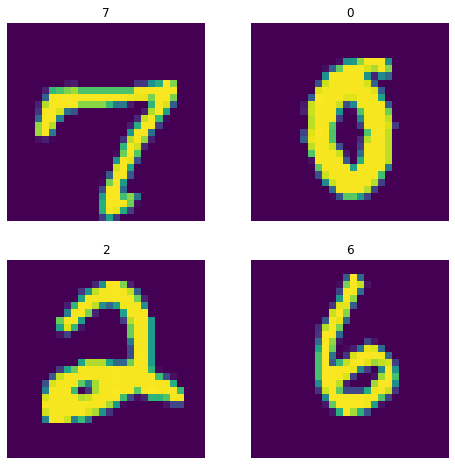

In [7]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [9]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

#Metaparametros a variar 

##n_epoch = Número de épocas
##lr = Tasa de aprendizaje - learning rate
##weight_decay = peso de decaímiento
##batch_size = Tamaño del subconjunto

#Modelo 1 

In [19]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)
  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

  0%|          | 0/36 [00:00<?, ?it/s]

ne: 50, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.8960976004600525. f1:0.8037091069672577 acc: 0.8034999966621399 


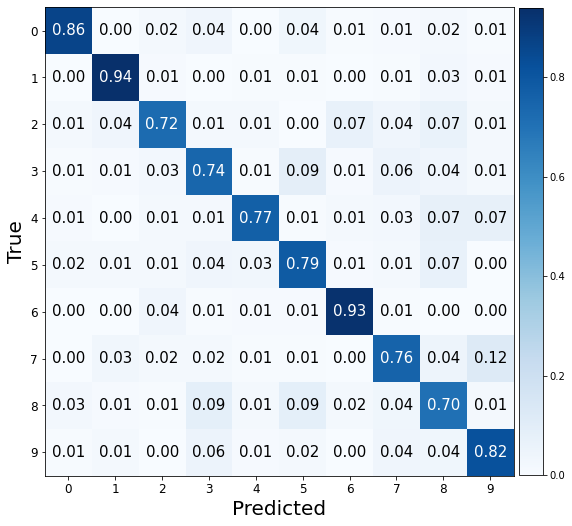

###################

ne: 50, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.9460777640342712. f1:0.7739930840555495 acc: 0.7730000019073486 


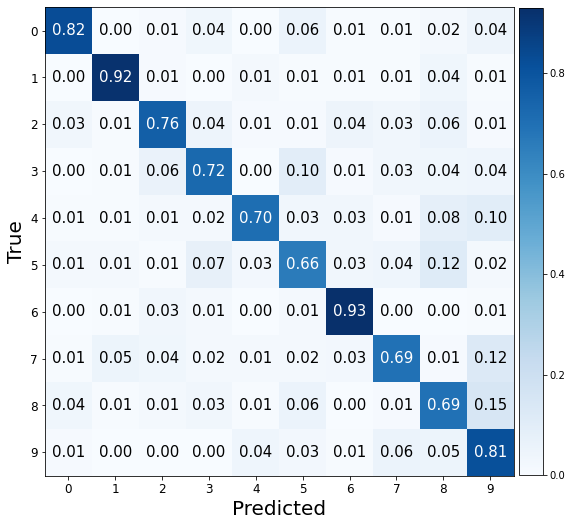

###################

ne: 50, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.897275686264038. f1:0.2980604331973484 acc: 0.3059999942779541 


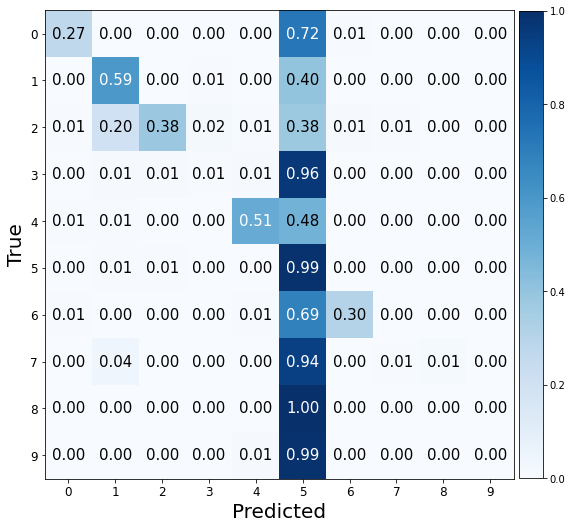

###################

ne: 50, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.8434171676635742. f1:0.2809171315285893 acc: 0.3240000009536743 


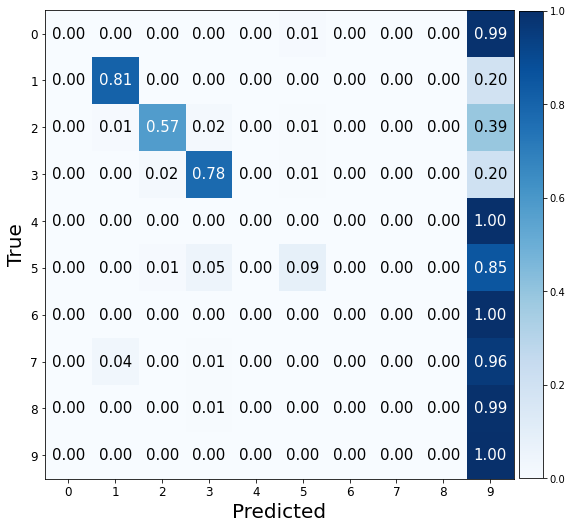

###################

ne: 50, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8444790244102478. f1:0.8093974192556063 acc: 0.809499979019165 


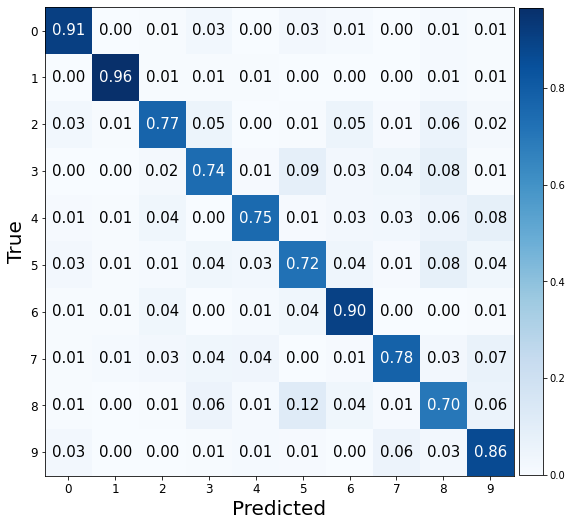

###################

ne: 50, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8912400603294373. f1:0.7898955422574928 acc: 0.7914999723434448 


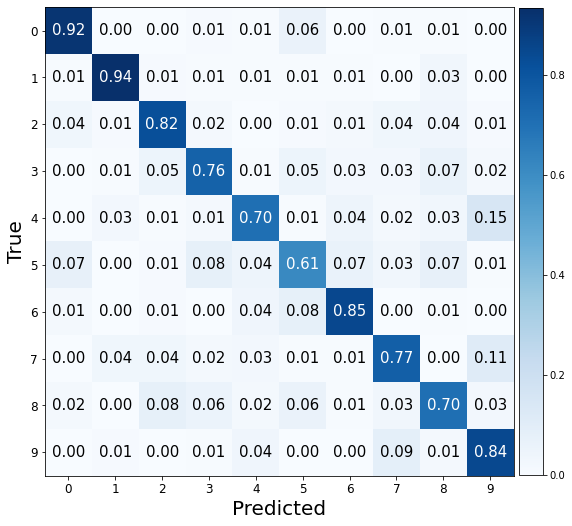

###################

ne: 50, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.7827907800674438. f1:0.3752364241278381 acc: 0.4154999852180481 


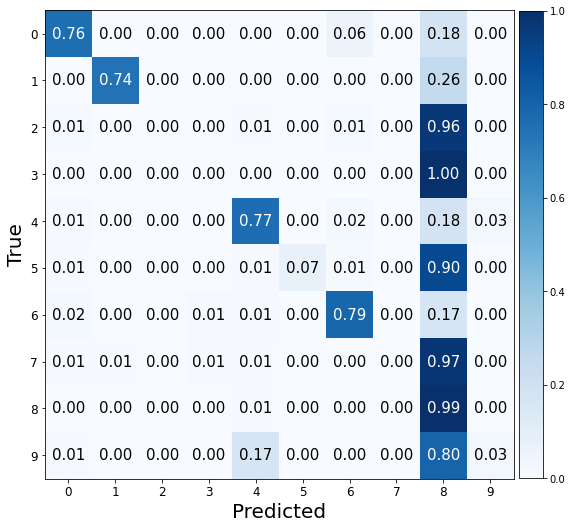

###################

ne: 50, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.6131824254989624. f1:0.45374967021010637 acc: 0.4699999988079071 


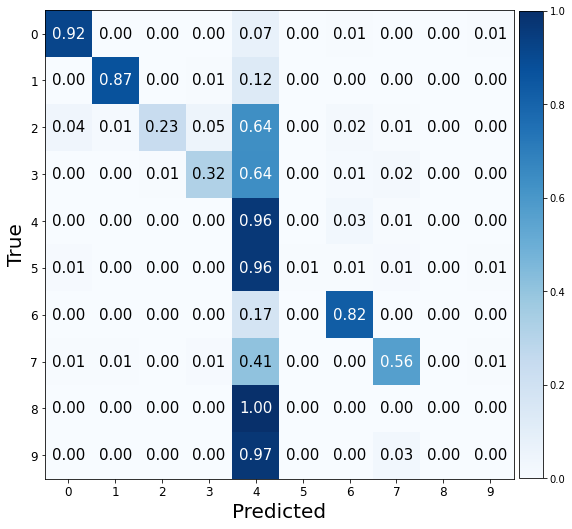

###################

ne: 50, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.9985624551773071. f1:0.8160773183747951 acc: 0.8159999847412109 


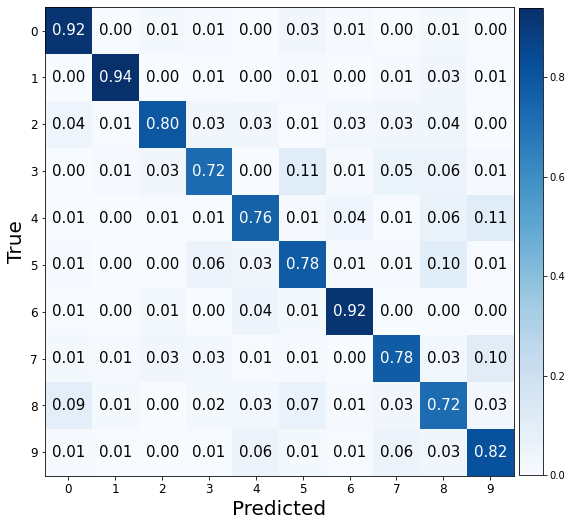

###################

ne: 50, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6746968626976013. f1:0.842238932221836 acc: 0.8429999947547913 


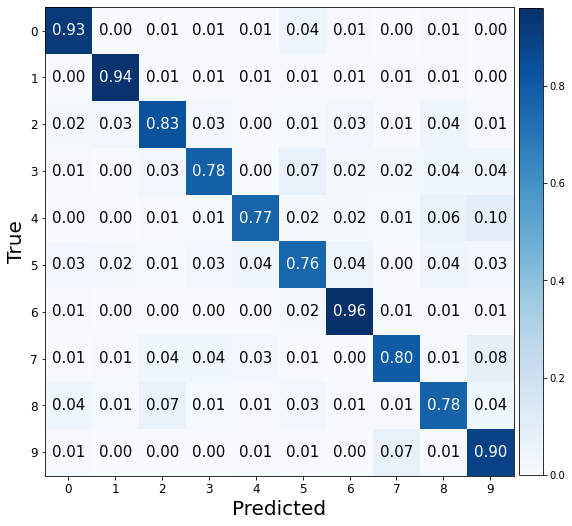

###################

ne: 50, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.8068629503250122. f1:0.26950715334763864 acc: 0.33399999141693115 


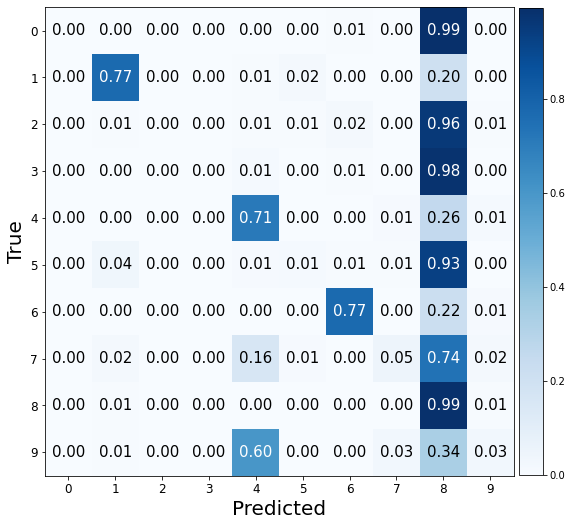

###################

ne: 50, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 2.0128345489501953. f1:0.23049873678152993 acc: 0.25200000405311584 


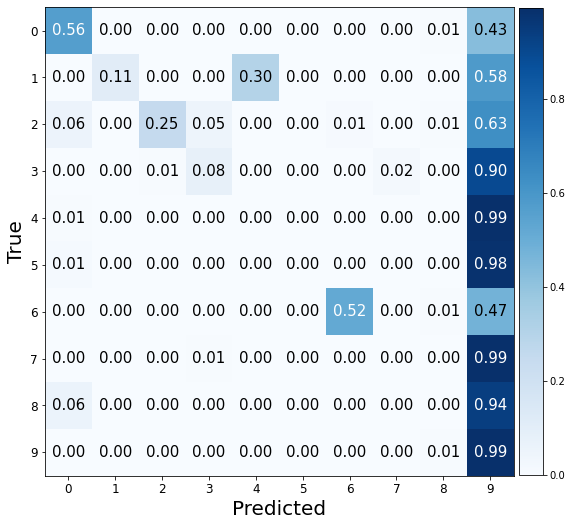

###################

ne: 100, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6851118803024292. f1:0.8527028129846018 acc: 0.8525000214576721 


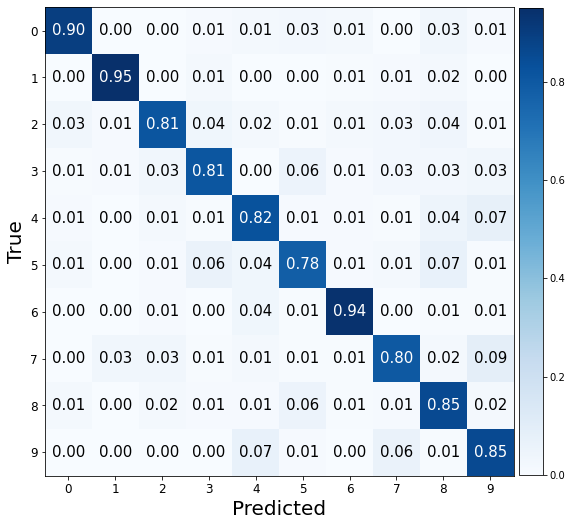

###################

ne: 100, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6203211545944214. f1:0.8656780561939726 acc: 0.8659999966621399 


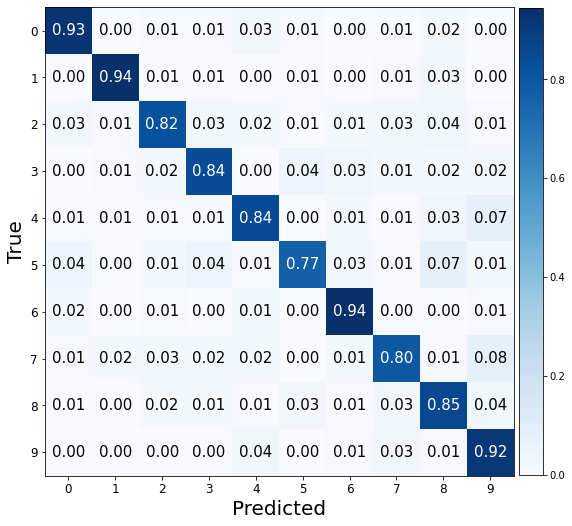

###################

ne: 100, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.6170408725738525. f1:0.5436932083408432 acc: 0.565500020980835 


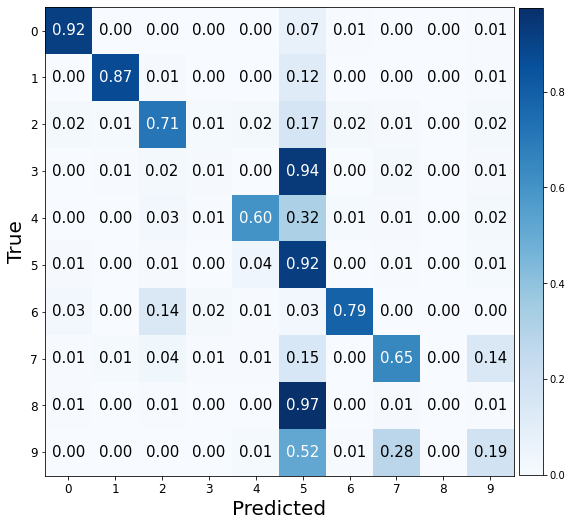

###################

ne: 100, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.1395851373672485. f1:0.6456624190087096 acc: 0.6664999723434448 


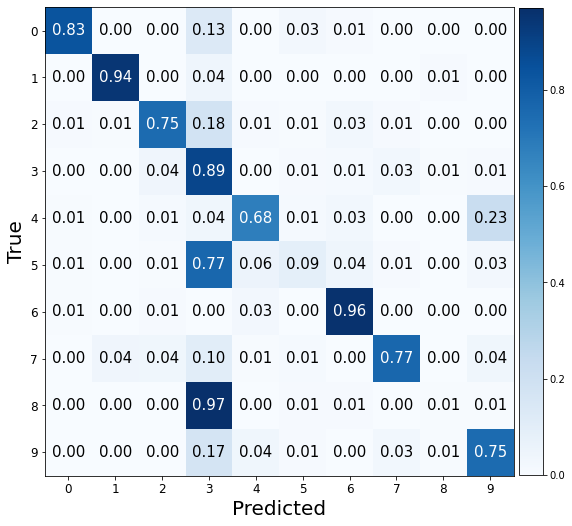

###################

ne: 100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6629443168640137. f1:0.859258132188166 acc: 0.8600000143051147 


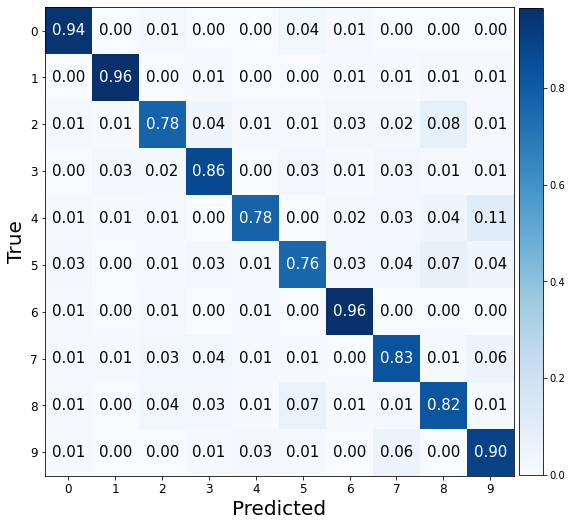

###################

ne: 100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6918553709983826. f1:0.8452050630263279 acc: 0.8454999923706055 


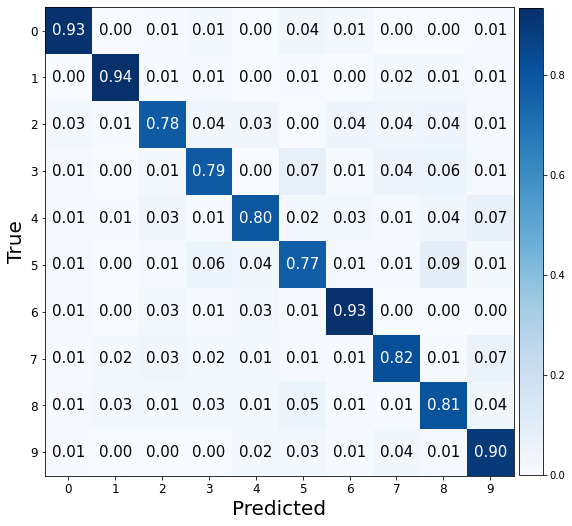

###################

ne: 100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.493649959564209. f1:0.5523378579554805 acc: 0.5745000243186951 


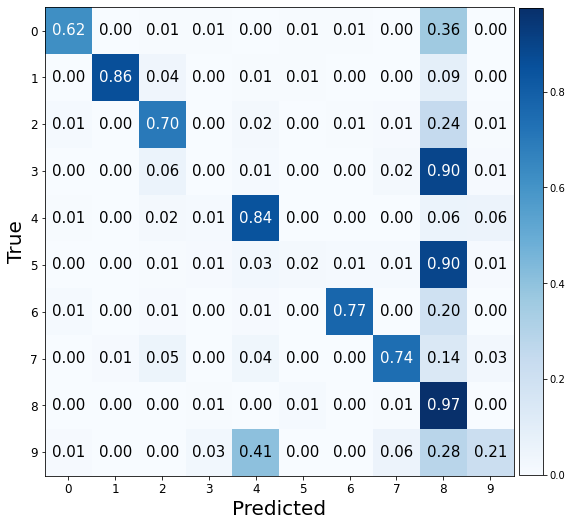

###################

ne: 100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.8125262260437012. f1:0.2744972992308305 acc: 0.33149999380111694 


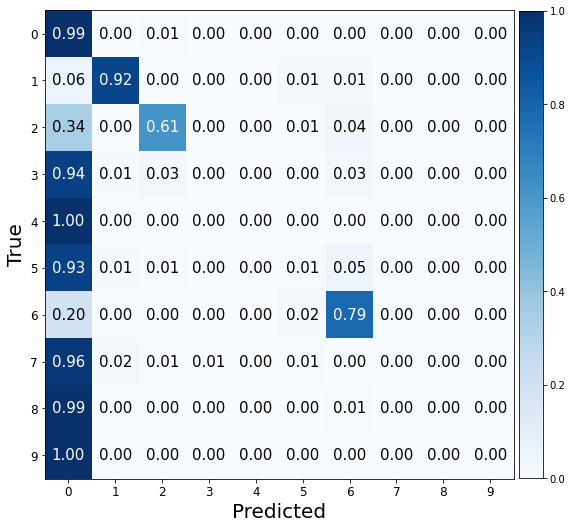

###################

ne: 100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6710758805274963. f1:0.8462776074667613 acc: 0.8460000157356262 


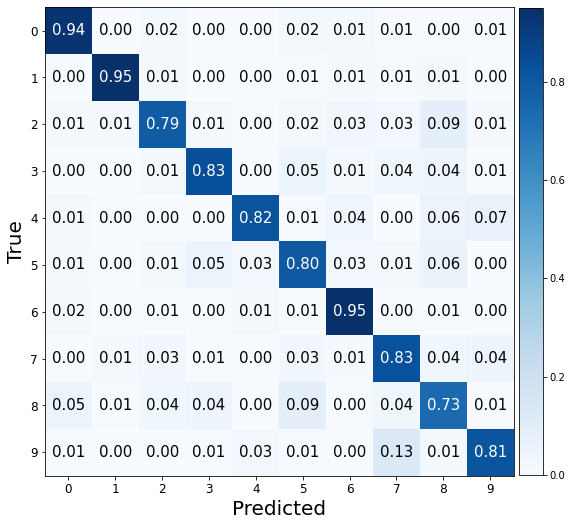

###################

ne: 100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7644625902175903. f1:0.8238326797366351 acc: 0.8240000009536743 


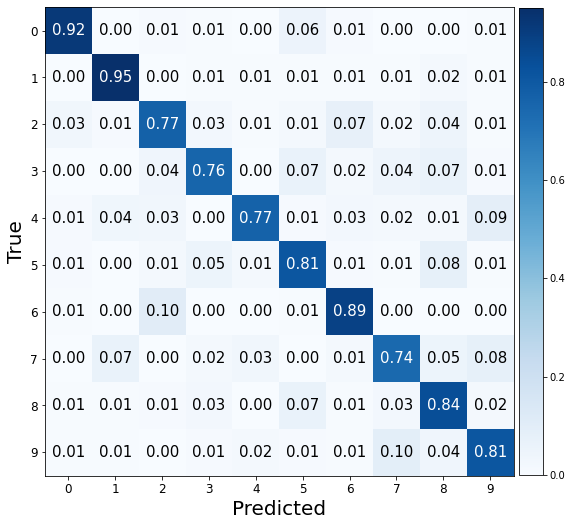

###################

ne: 100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.685298204421997. f1:0.35367230596846355 acc: 0.398499995470047 


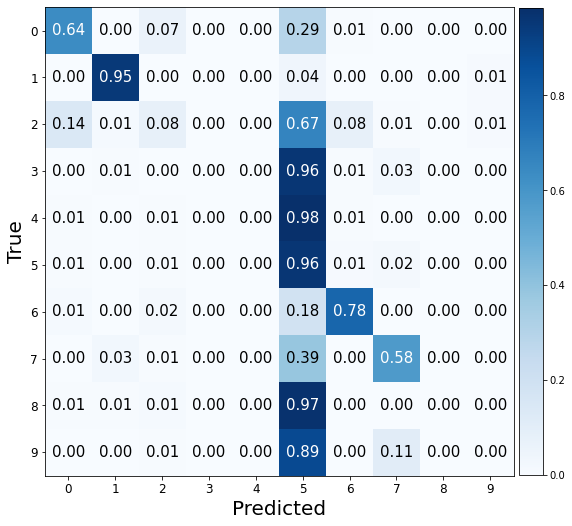

###################

ne: 100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.3935853242874146. f1:0.5982730064413286 acc: 0.6075000166893005 


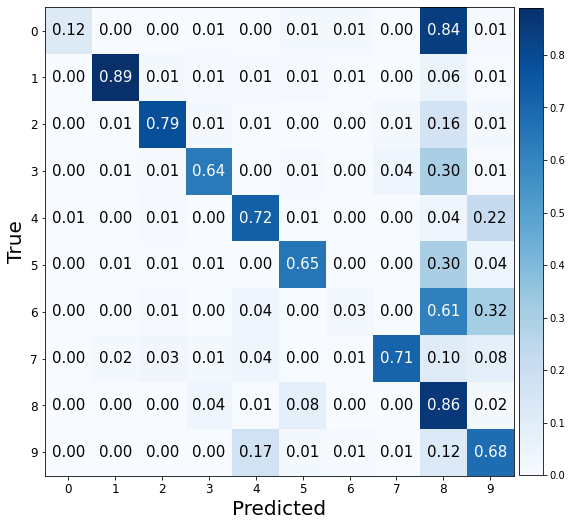

###################

ne: 150, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6837024092674255. f1:0.8652434087253672 acc: 0.8650000095367432 


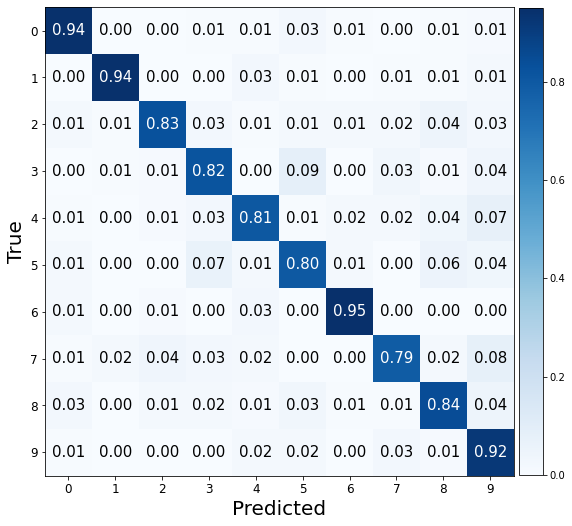

###################

ne: 150, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6369686722755432. f1:0.8792607991386688 acc: 0.8794999718666077 


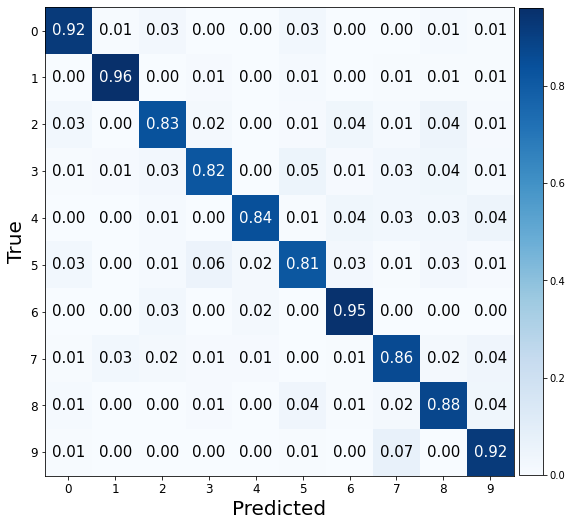

###################

ne: 150, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.1610615253448486. f1:0.7172627111746185 acc: 0.718999981880188 


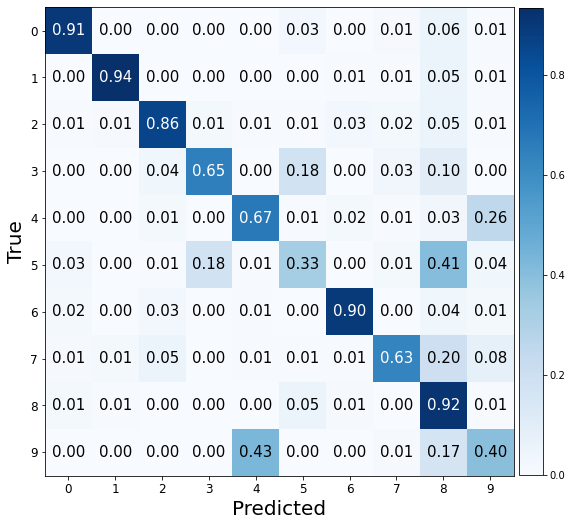

###################

ne: 150, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.15826416015625. f1:0.6523431757261632 acc: 0.6729999780654907 


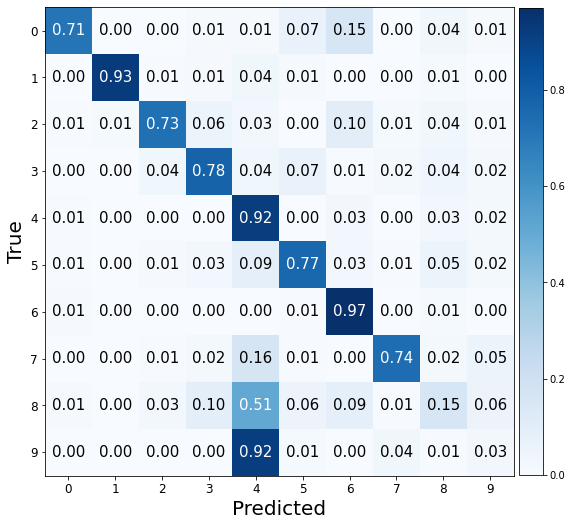

###################

ne: 150, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.7757285237312317. f1:0.8761575300339401 acc: 0.8765000104904175 


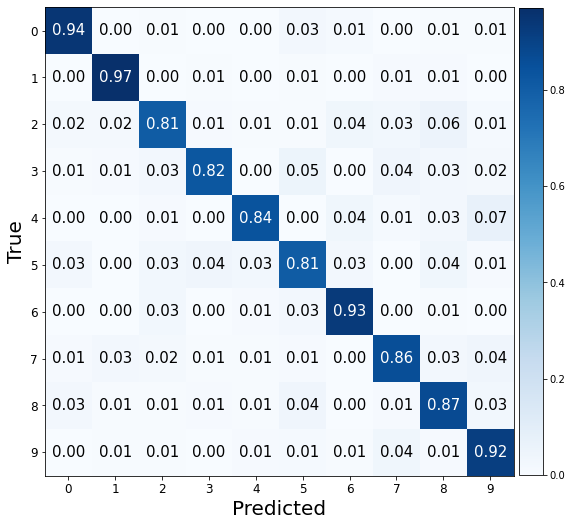

###################

ne: 150, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8170132040977478. f1:0.8521795466439652 acc: 0.8525000214576721 


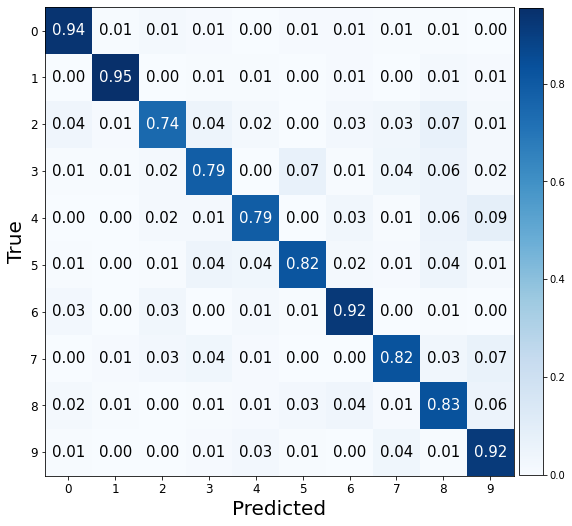

###################

ne: 150, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.3562562465667725. f1:0.7153805670494275 acc: 0.7160000205039978 


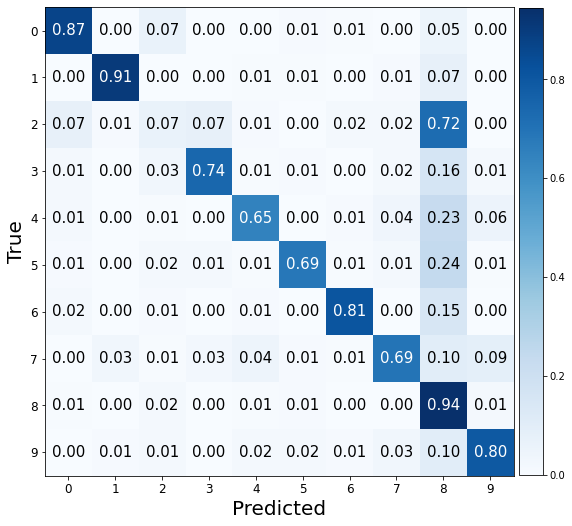

###################

ne: 150, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.3169708251953125. f1:0.5845068833764213 acc: 0.6069999933242798 


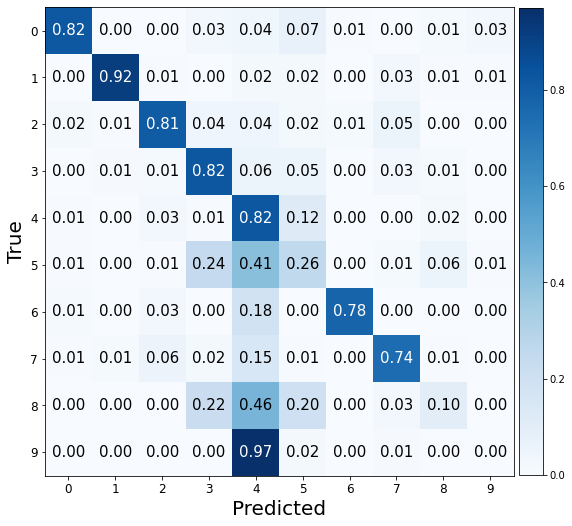

###################

ne: 150, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6644871234893799. f1:0.8703438115468799 acc: 0.8700000047683716 


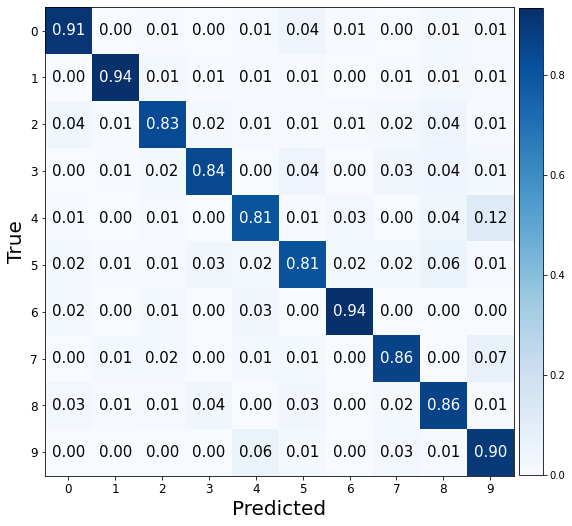

###################

ne: 150, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6286311149597168. f1:0.8718373106209494 acc: 0.871999979019165 


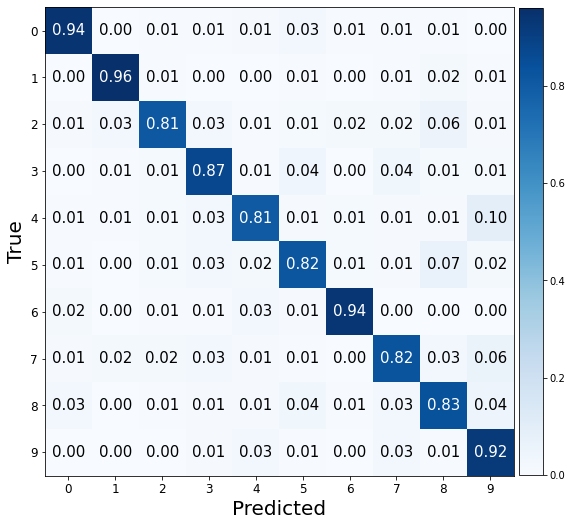

###################

ne: 150, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.590169906616211. f1:0.475140517885387 acc: 0.5040000081062317 


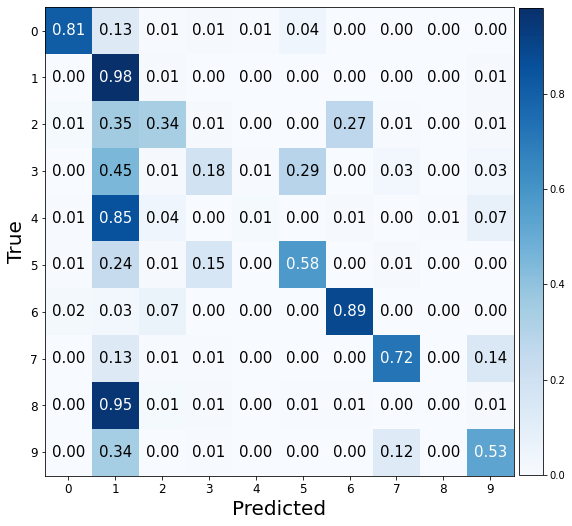

###################

ne: 150, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.060080885887146. f1:0.7317907794759468 acc: 0.7294999957084656 


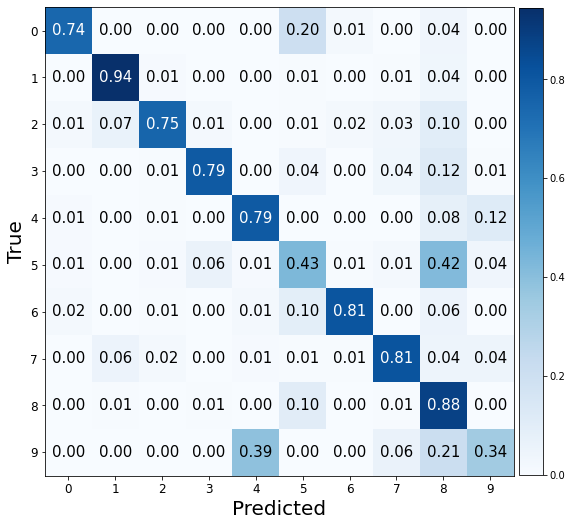

###################



In [29]:

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [256,512,1024]
lr_list = [0.001,0.01]
wd_list = [0.001,0.01]
hidden = 50
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        train_valid(model,ne,optimizer,criterion)
        print('###################\n')

        pbar.update()
pbar.close()

#Modelo 2 

  0%|          | 0/36 [00:00<?, ?it/s]

ne: 50, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.34013307094573975. f1:0.8996555227638984 acc: 0.8999999761581421 


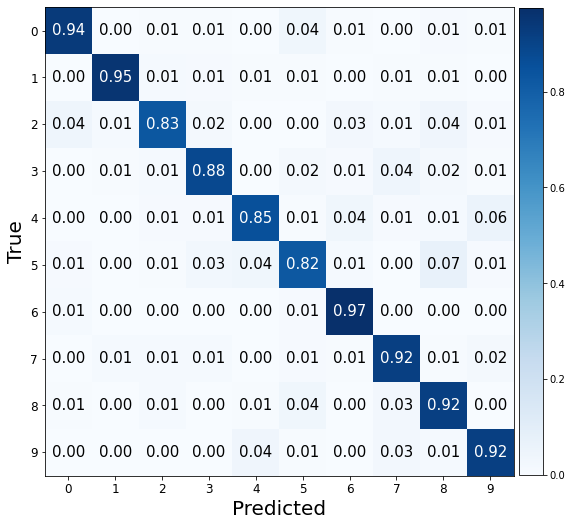

###################

ne: 50, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.36830538511276245. f1:0.8893542330004027 acc: 0.8895000219345093 


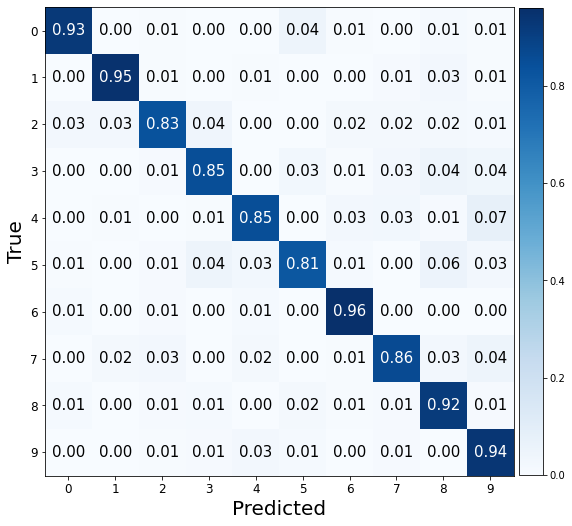

###################

ne: 50, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 0.7299477458000183. f1:0.7937677633250486 acc: 0.7925000190734863 


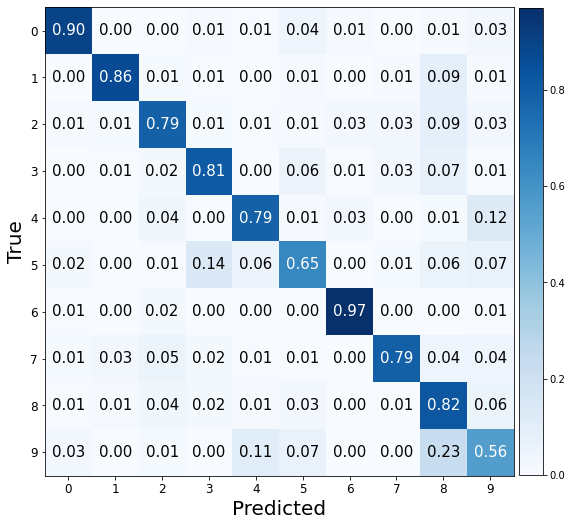

###################

ne: 50, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 0.6215853691101074. f1:0.8148091210035888 acc: 0.8149999976158142 


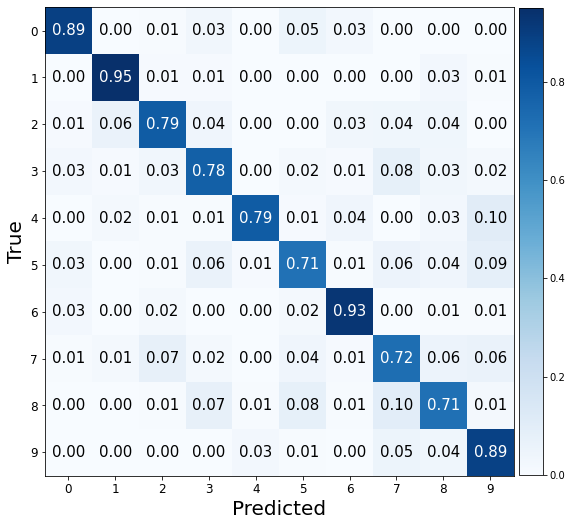

###################

ne: 50, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.36065125465393066. f1:0.8933666715070819 acc: 0.8934999704360962 


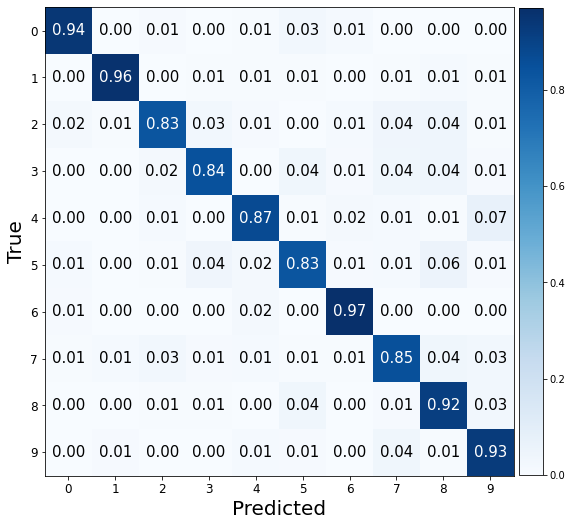

###################

ne: 50, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.35363101959228516. f1:0.8974540220221391 acc: 0.8974999785423279 


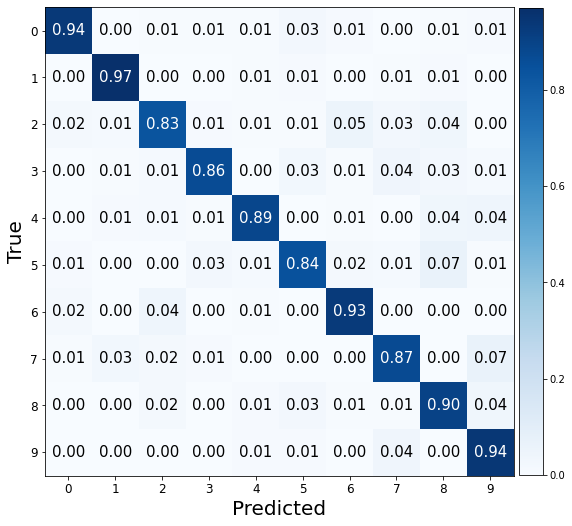

###################

ne: 50, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.5379093885421753. f1:0.8471774327974488 acc: 0.8464999794960022 


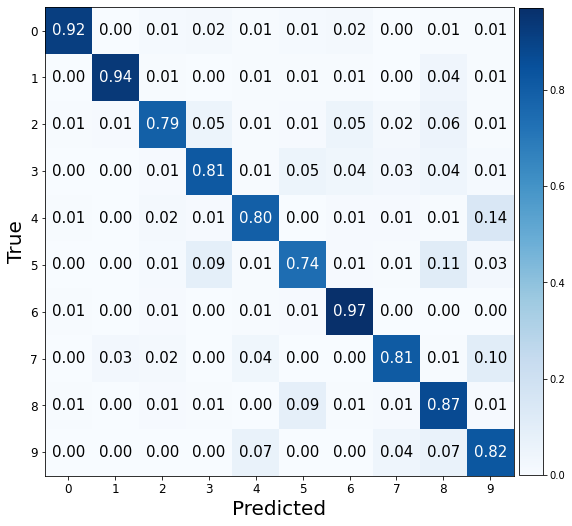

###################

ne: 50, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 0.47671425342559814. f1:0.8597521122182435 acc: 0.859499990940094 


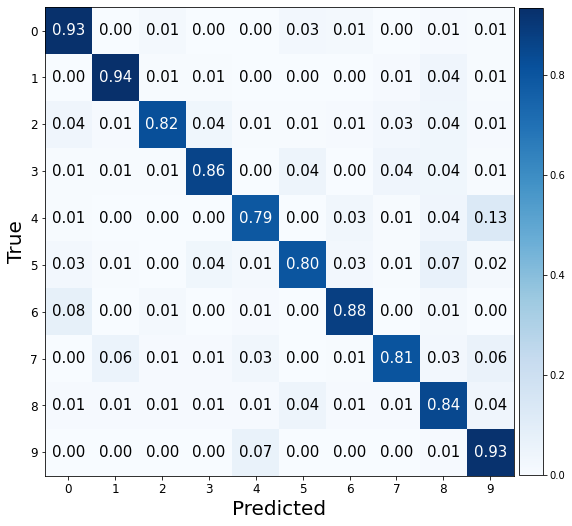

###################

ne: 50, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.3755493462085724. f1:0.8967288380029272 acc: 0.8964999914169312 


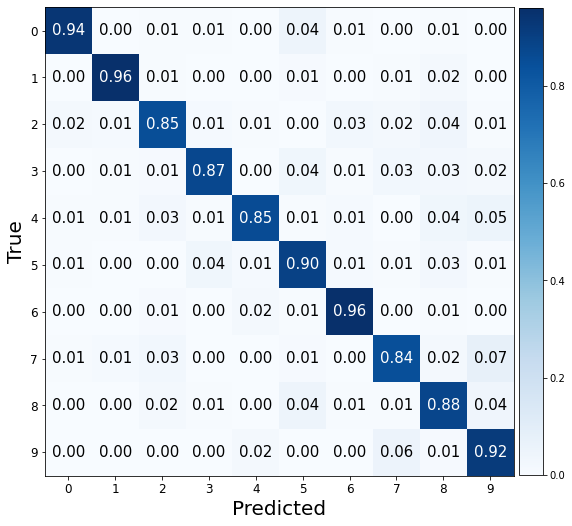

###################

ne: 50, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.4166928827762604. f1:0.8759046322626821 acc: 0.8759999871253967 


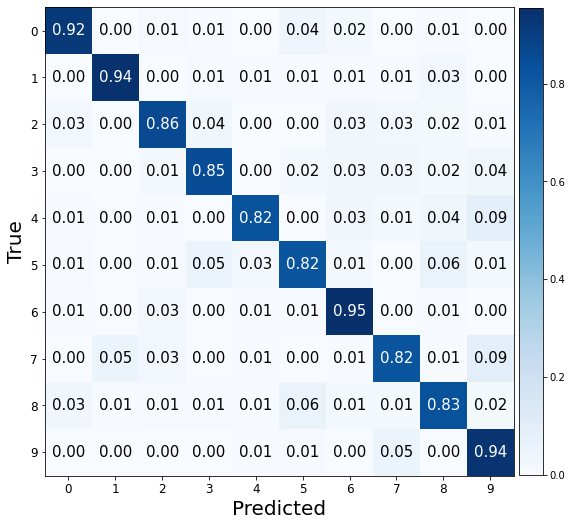

###################

ne: 50, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.6777501702308655. f1:0.7899475051444134 acc: 0.7925000190734863 


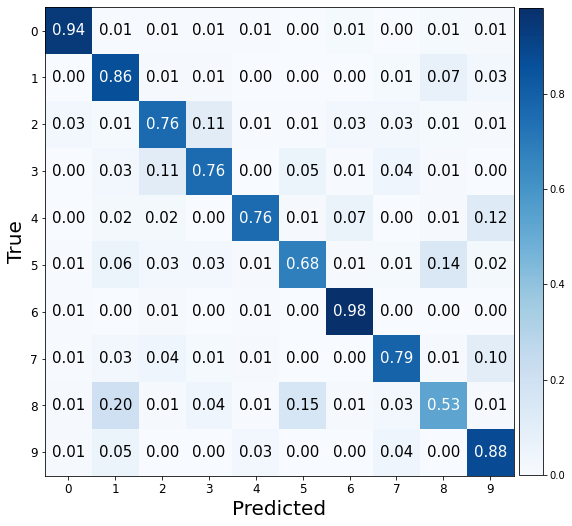

###################

ne: 50, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.5021549463272095. f1:0.8462282303504157 acc: 0.8464999794960022 


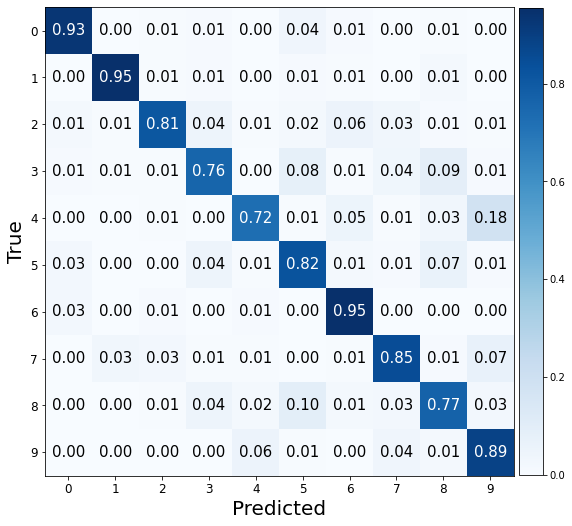

###################

ne: 100, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.2874598801136017. f1:0.9116549120778898 acc: 0.9114999771118164 


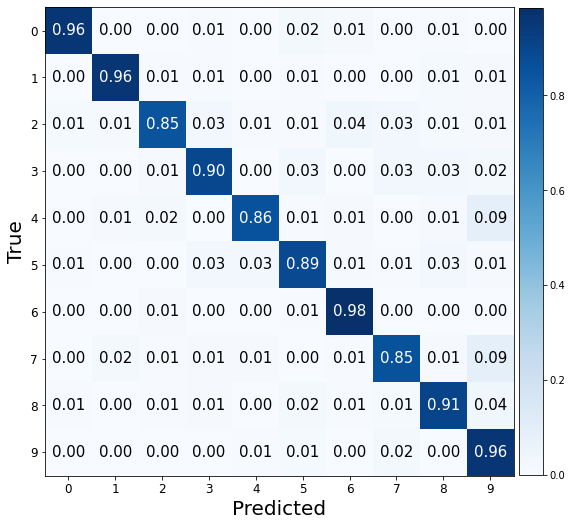

###################

ne: 100, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.3049456477165222. f1:0.9092135617868893 acc: 0.9100000262260437 


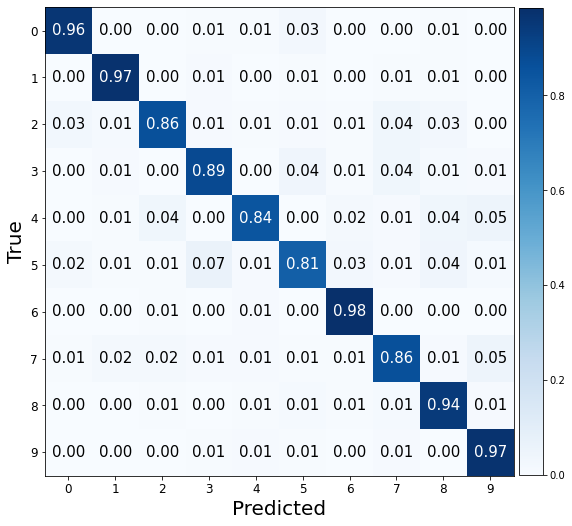

###################

ne: 100, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.1012163162231445. f1:0.5753324703602204 acc: 0.5979999899864197 


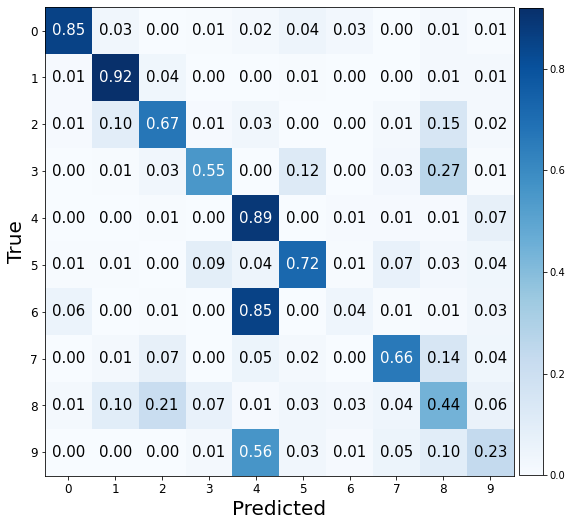

###################

ne: 100, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 0.43497031927108765. f1:0.8860594931339524 acc: 0.8855000138282776 


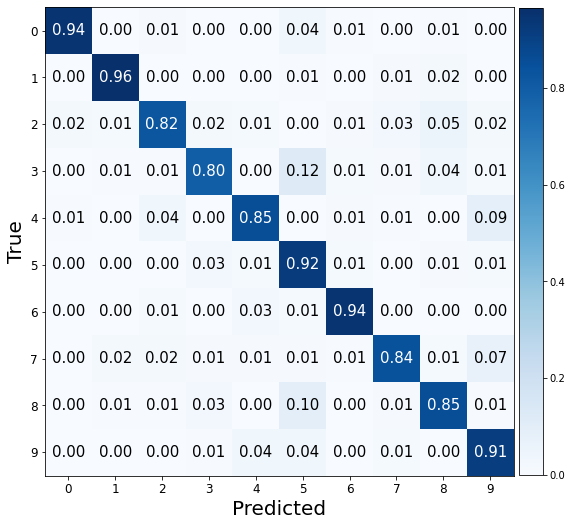

###################

ne: 100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.34722453355789185. f1:0.9139842655762624 acc: 0.9139999747276306 


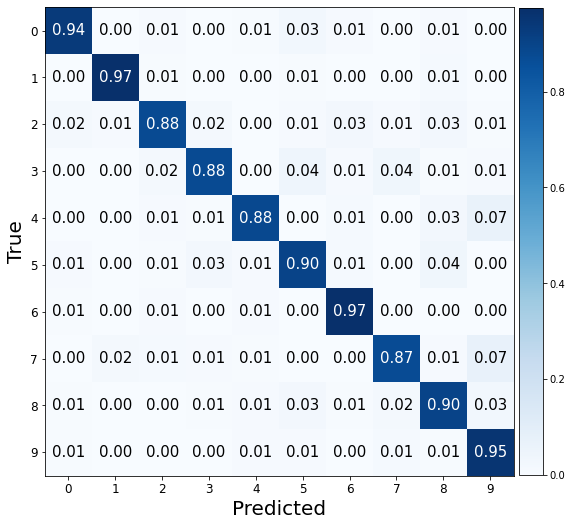

###################

ne: 100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.28215816617012024. f1:0.9178608477142088 acc: 0.9179999828338623 


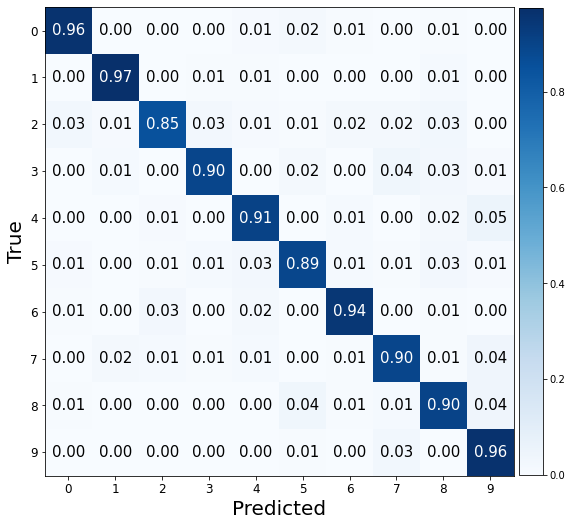

###################

ne: 100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.43103915452957153. f1:0.8784729283637462 acc: 0.8790000081062317 


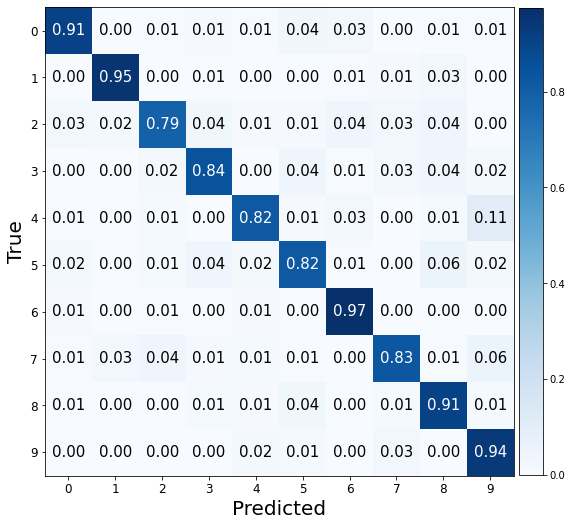

###################

ne: 100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 0.6534518599510193. f1:0.7833266849314695 acc: 0.7829999923706055 


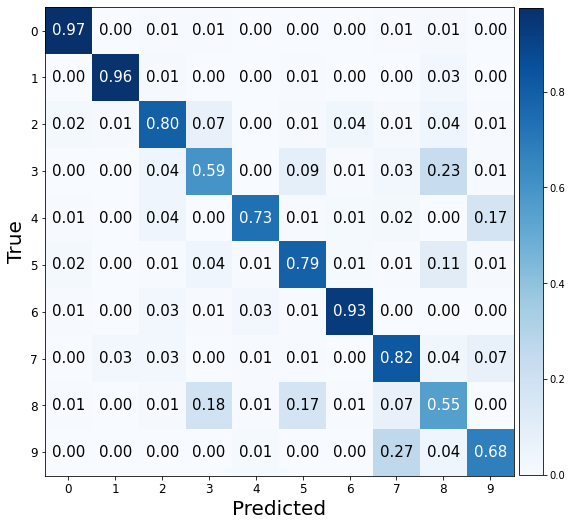

###################

ne: 100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.3099004328250885. f1:0.917198614174503 acc: 0.9175000190734863 


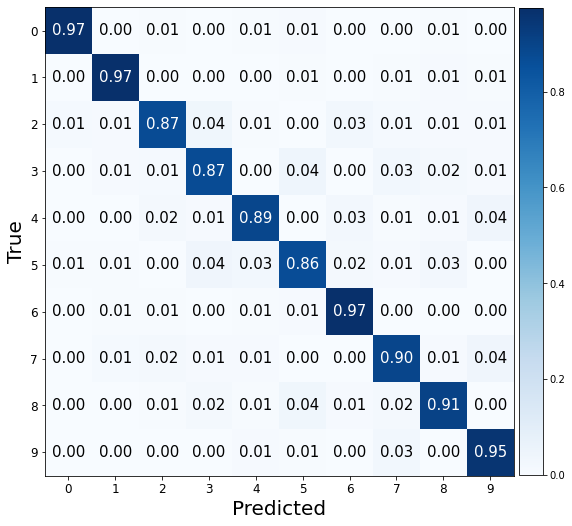

###################

ne: 100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.2848139703273773. f1:0.9153670908896767 acc: 0.9154999852180481 


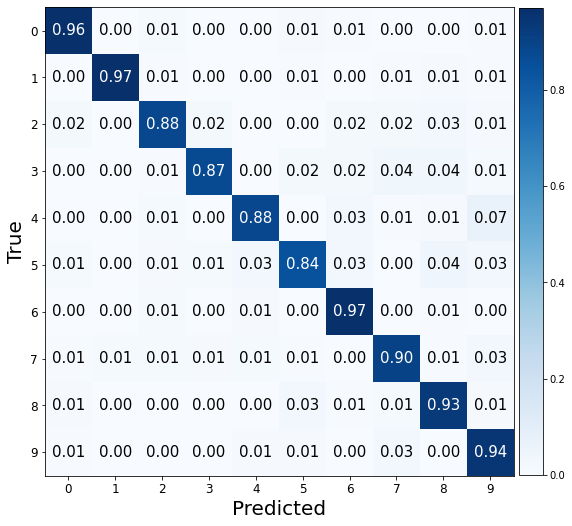

###################

ne: 100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.4095785617828369. f1:0.8901095835823654 acc: 0.890500009059906 


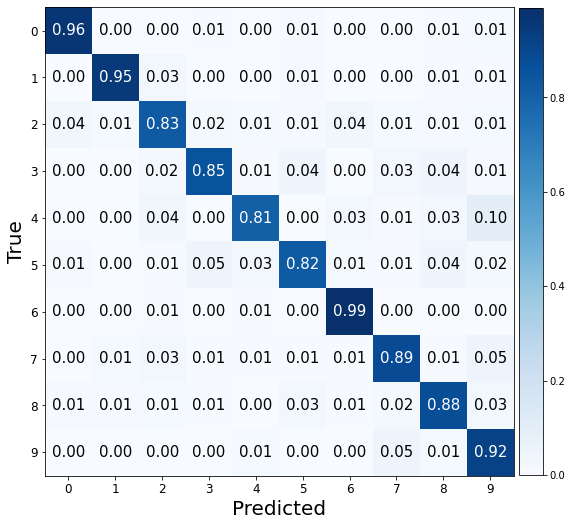

###################

ne: 100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.5357227325439453. f1:0.8412206950457941 acc: 0.8420000076293945 


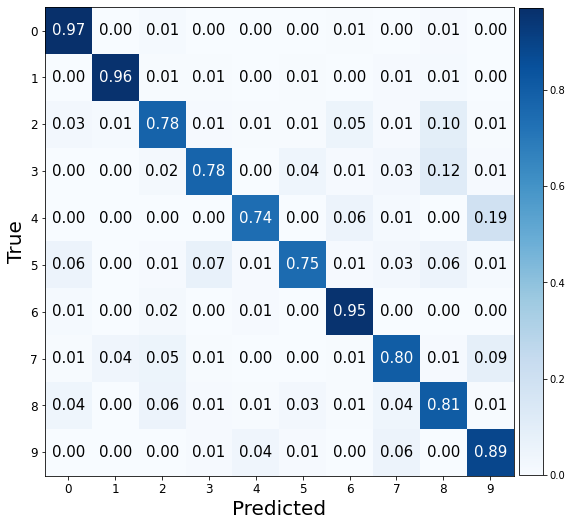

###################

ne: 150, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.342214435338974. f1:0.9222766768131955 acc: 0.9225000143051147 


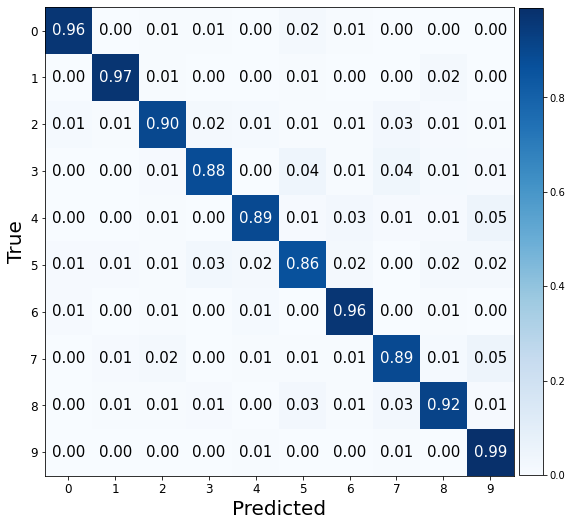

###################

ne: 150, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.2899084985256195. f1:0.9116346295654127 acc: 0.9120000004768372 


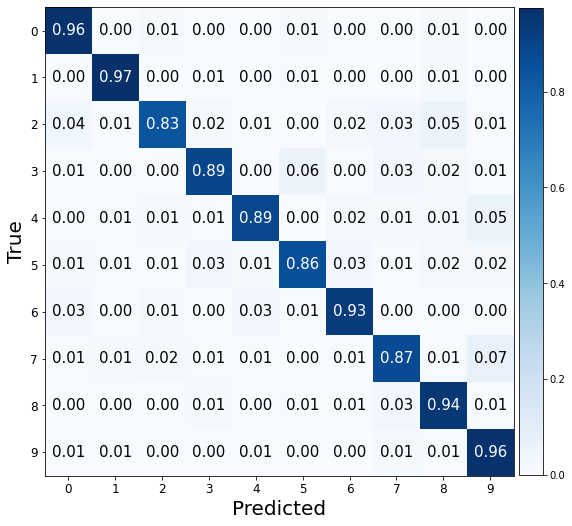

###################

ne: 150, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 0.5017902851104736. f1:0.8748001224178233 acc: 0.875 


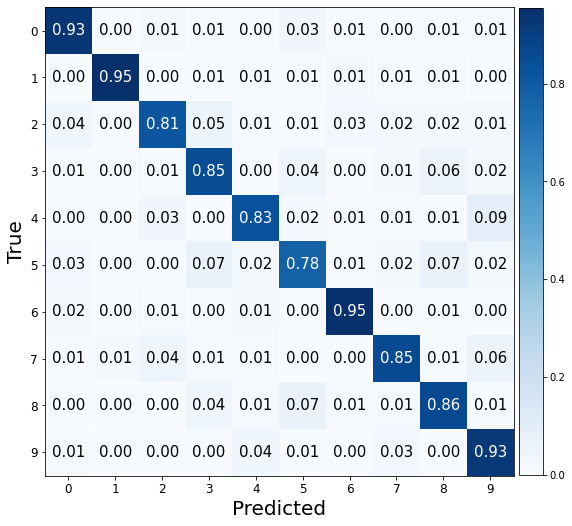

###################

ne: 150, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 0.39120325446128845. f1:0.8946680960236539 acc: 0.8949999809265137 


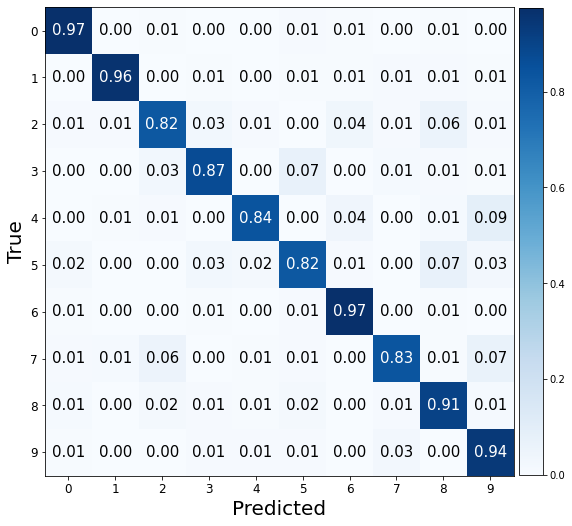

###################

ne: 150, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.3314847946166992. f1:0.916752132776994 acc: 0.9169999957084656 


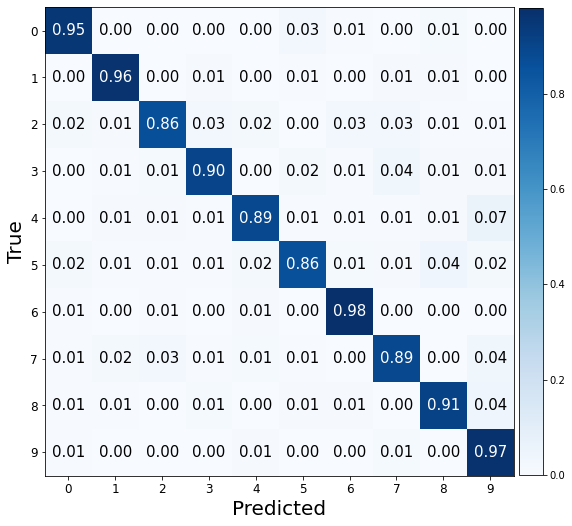

###################

ne: 150, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.27649471163749695. f1:0.9222452010708496 acc: 0.9225000143051147 


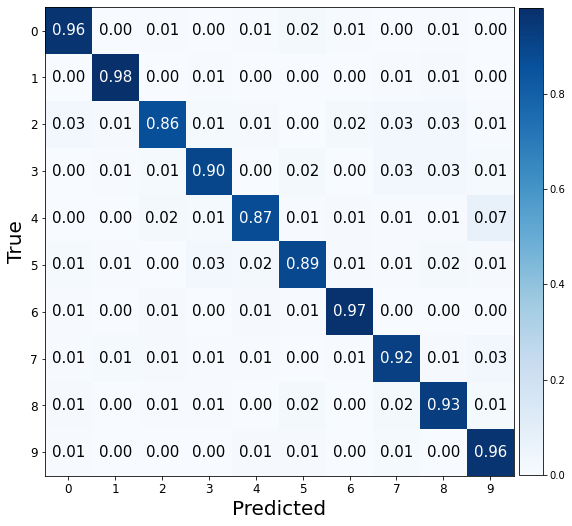

###################

ne: 150, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.5894126296043396. f1:0.8714127319724314 acc: 0.8709999918937683 


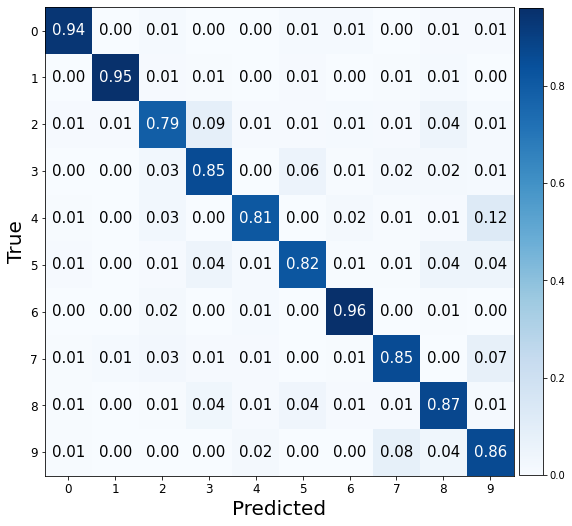

###################

ne: 150, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 0.426488995552063. f1:0.9035121930016515 acc: 0.9035000205039978 


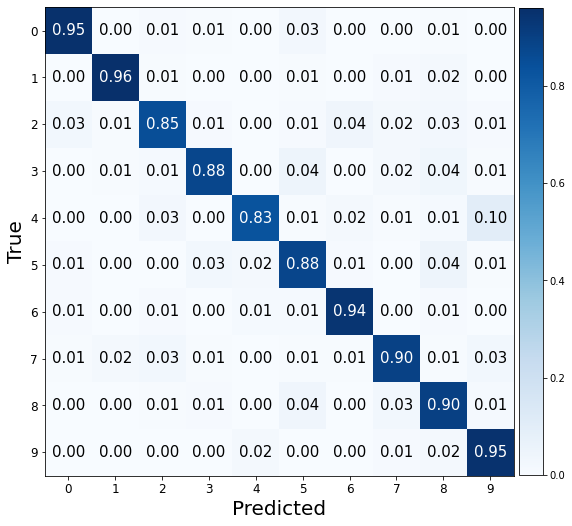

###################

ne: 150, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.32640933990478516. f1:0.9284616024314685 acc: 0.9284999966621399 


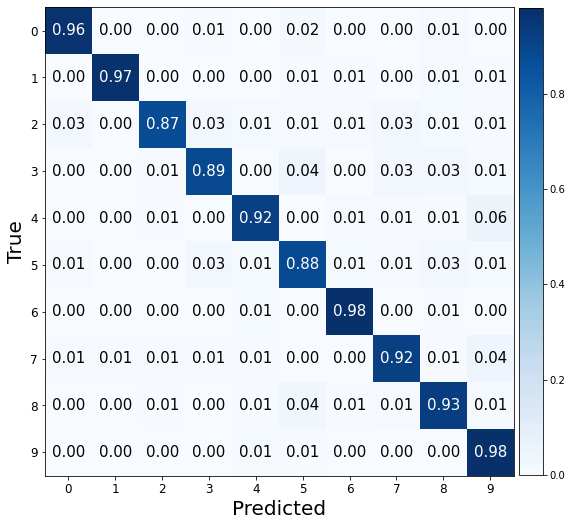

###################

ne: 150, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.2758238613605499. f1:0.9228891827332836 acc: 0.9229999780654907 


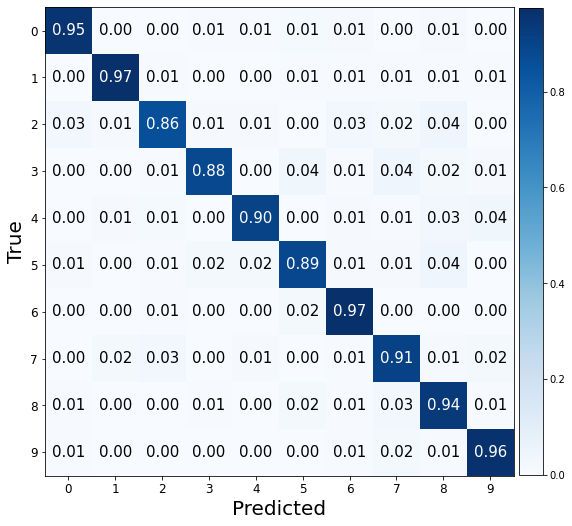

###################

ne: 150, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.5684395432472229. f1:0.898030753500114 acc: 0.8985000252723694 


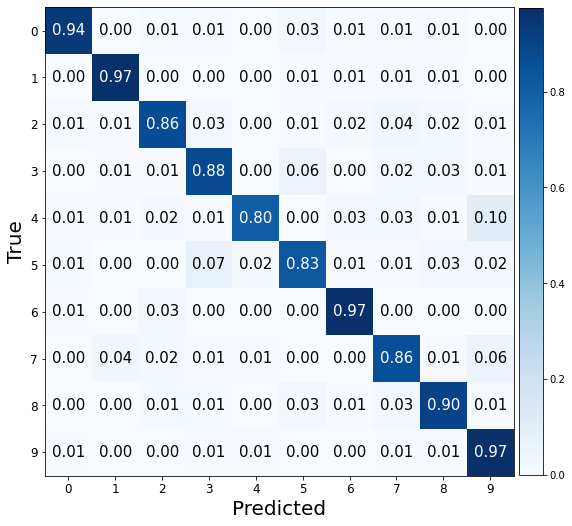

###################

ne: 150, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.8348228931427002. f1:0.11337116064373029 acc: 0.21799999475479126 


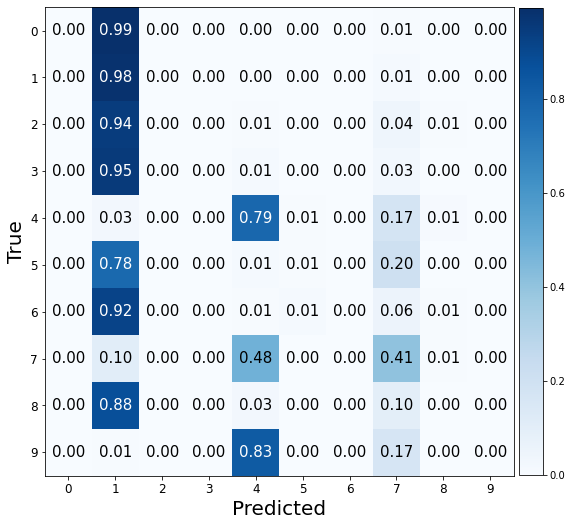

###################



In [31]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [256,512,1024]
lr_list = [0.001,0.01]
wd_list = [0.001,0.01]
hidden = 50
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim),
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        train_valid(model,ne,optimizer,criterion)
        print('###################\n')

        pbar.update()
pbar.close()

#Análisis
##Se usaron dos modelos ambos con 50 neuronas ocultas, pero el segundo con más capas, en general, el segundo modelo obtuvo mejores resultados ya que solo 2 matrices no tienen los máximos exactamente en la diagonal, en cambio para el primer modelo alrededor de 10 matrices no tenían los máximos en la diagonal.
##Los parámetros que mejores resultados obtuvieron fue learning rate de 0.001 para ambos modelos, el valor de 0.01 hacía que los resultados fueran menos precisos, el número de épocas no fue muy diferente entre 100 y 150 pero entre 50 y 100 si hubo gran diferencia, el valor más adecuado fue el de 150 pero el de 100 es suficiente para obtener buenos resultados, en cuanto al weight decay suele ser mejor el valor de 0.001 pero la diferencia con 0.01 no es tanta como en el learning rate, en cuanto al batch size no es mucha la diferncia pero el menor valor (256) obtuvo resultados ligeramente mejores, debido a que el modelo aprende más por cada época. 

#Mejores resultados

Valid Evaluation loss: 0.3445795476436615. f1:0.9108245443050395 acc: 0.9110000133514404 


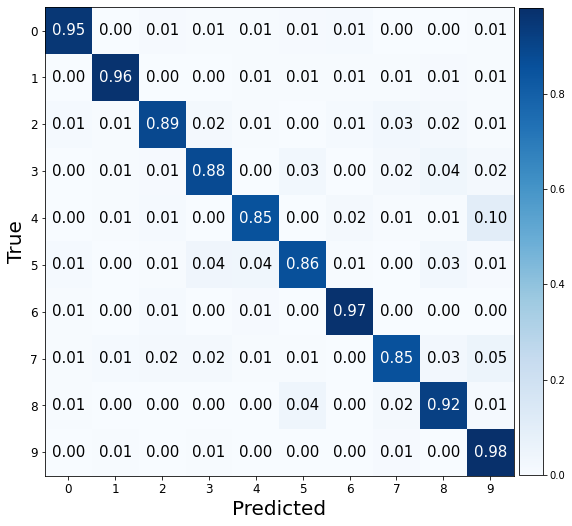

###################



In [35]:
#ne: 100, wd:0.001, lr: 0.001, bs:256

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
input_dim = 28*28
out_dim = 10
model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim),
  )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()


train_valid(model,100,optimizer,criterion)
print('###################\n')

   

Valid Evaluation loss: 0.3380463123321533. f1:0.916847643252048 acc: 0.9169999957084656 


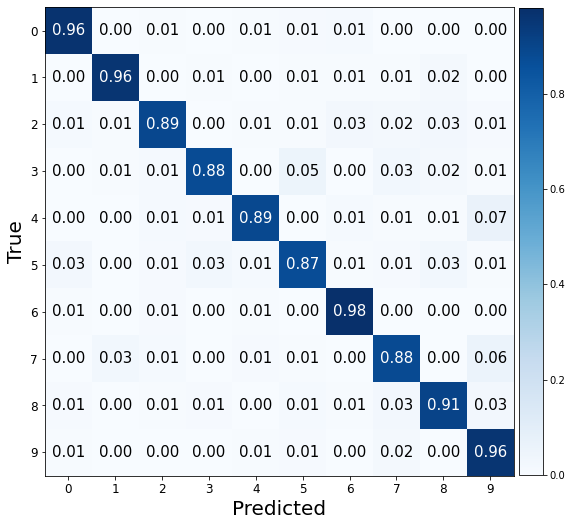

###################



In [37]:
#ne: 150, wd:0.001, lr: 0.001, bs:256

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
input_dim = 28*28
out_dim = 10
model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim),
  )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()


train_valid(model,150,optimizer,criterion)
print('###################\n')